# Análisis Exploratorio de Datos ( EDA )

En este Notebook, entenderemos los datos, describiremos y analizaremos para poder llegar a crear un set de datos óptimo para el algoritmo de recomendación. El algoritmo de recomendación para el cual se van a optimizar los datos serán:

```
def recomendacion_juego( id de producto ): Ingresando el id de producto, deberíamos recibir una lista con 5 juegos recomendados similares al ingresado.
```
En un futuro se implementará el algoritmo de usuario a item:

```
def recomendacion_usuario( id de usuario ): Ingresando el id de un usuario, deberíamos recibir una lista con 5 juegos recomendados para dicho usuario.
```

# 1. Importamos las librerías necesarias

In [1]:
import pandas as pd # Con pandas trabajaremos los datos.
import ast # Convertiremos una cadena de texto a una lista con ast.
import matplotlib.pyplot as plt # Con matplotlib graficaremos nuestros datos.
from sklearn.decomposition import PCA # Con PCA, haremos una reducción de dimensionalidad, ya que sabemos que hay demasiadas variables categóricas en nuestro dataframe de juegos, solo queremos las principales y que más nos aporten.
import seaborn as sns # Con seaborn, haremos gráficos de nuestros datos.

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_26384\1949750693.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # Con pandas trabajaremos los datos.


# 2. Cargamos y previsualizamos cada set de datos.
Por ahora solo necesitaremos el set de juegos, cuando se implemente el otro algoritmo, necesitaremos los demás.

In [2]:
df_game = pd.read_csv('../Data/Processed/games_recommend.csv')

In [3]:
df_game.head()

,publisher,genres,name,specs,price,early_access,id,developer,year
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,['Single-player'],4.99,0.0,761140,Kotoshiro,2018
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,"['Single-player', 'Multi-player', 'Online Mult...",0.00,0.0,643980,Secret Level SRL,2018
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,"['Single-player', 'Multi-player', 'Online Mult...",0.00,0.0,670290,Poolians.com,2017
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,['Single-player'],0.99,0.0,767400,彼岸领域,2017
4,Trickjump Games Ltd,"['Action', 'Adventure', 'Simulation']",Battle Royale Trainer,"['Single-player', 'Steam Achievements']",3.99,0.0,772540,Trickjump Games Ltd,2018


# 3. Seleccionamos las columnas objetivo de nuestro algoritmo.
Creamos el set de datos con el que trabajaremos con el algoritmo de recomendación.

In [4]:
df_games = df_game[['id', 'genres', 'specs', 'early_access', 'name']] # Recomendación de item en base a un item.
# En este caso extraemos el id, necesario para la búsqueda, junto con el nombre para el resultado, y las variables specs, genres y early_access, que serán las características del juego, con las que podremos compararlo con otros juegos.

Convertimos las columnas que tienen listas para poder iterar sobre ellas.

In [5]:
df_games['genres'] = df_games['genres'].apply(ast.literal_eval)
df_games['specs'] = df_games['specs'].apply(ast.literal_eval)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_26384\1831853252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['genres'] = df_games['genres'].apply(ast.literal_eval)
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_26384\1831853252.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games['specs'] = df_games['specs'].apply(ast.literal_eval)


Creamos variables dummies de los géneros y las especificaciones.

In [6]:
genres_d = df_games['genres'].apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0) # Aplico una función que para cada elemento dentro de genres o specs, si está presente, le asigna un valor de 1 en una serie de pandas, y si no lo está, será 0.
specs_d = df_games['specs'].apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0)

Verificamos antes de agregarlas al dataframe.

In [7]:
display(genres_d.head())
specs_d.head()

,Action,Casual,Indie,Simulation,Strategy,Free to Play,RPG,Sports,Adventure,Racing,...,Remake,Time Attack,Anime,Side Scroller,Documentary,Controller,Memes,Detective,Mystery,Episodic
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Single-player,Multi-player,Online Multi-Player,Cross-Platform Multiplayer,Steam Achievements,Steam Trading Cards,In-App Purchases,Stats,Downloadable Content,Full controller support,...,Mods,MMO,Online Co-op,Local Multi-Player,Includes Source SDK,Commentary available,Steam Turn Notifications,SteamVR Collectibles,Game demo,Mods (require HL2)
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Las agregamos al dataframe y eliminamos las columnas restantes.

In [8]:
df_games = pd.concat([df_games, genres_d, specs_d], axis=1)
df_games.drop(columns=['genres', 'specs'], inplace=True)

In [9]:
df_games.head()

,id,early_access,name,Action,Casual,Indie,Simulation,Strategy,Free to Play,RPG,...,Mods,MMO,Online Co-op,Local Multi-Player,Includes Source SDK,Commentary available,Steam Turn Notifications,SteamVR Collectibles,Game demo,Mods (require HL2)
0,761140,0.0,Lost Summoner Kitty,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,643980,0.0,Ironbound,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,670290,0.0,Real Pool 3D - Poolians,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,767400,0.0,弹炸人2222,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,772540,0.0,Battle Royale Trainer,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Verificamos que la columna early access no requiera una transformación.

In [10]:
df_games['early_access'].unique()

array([0., 1.])

Verificamos que los datos hayan quedado limpios.

In [11]:
df_games.isna().sum().sum()

0

# 4. Análisis de datos (DataFrame IA)
Empezamos a entender el dataframe resultante.

## 4.1 Distribución

Observemos qué tan distribuidos están los géneros en nuestro dataframe.

Text(0.5, 1.0, 'Frecuencia de Géneros')

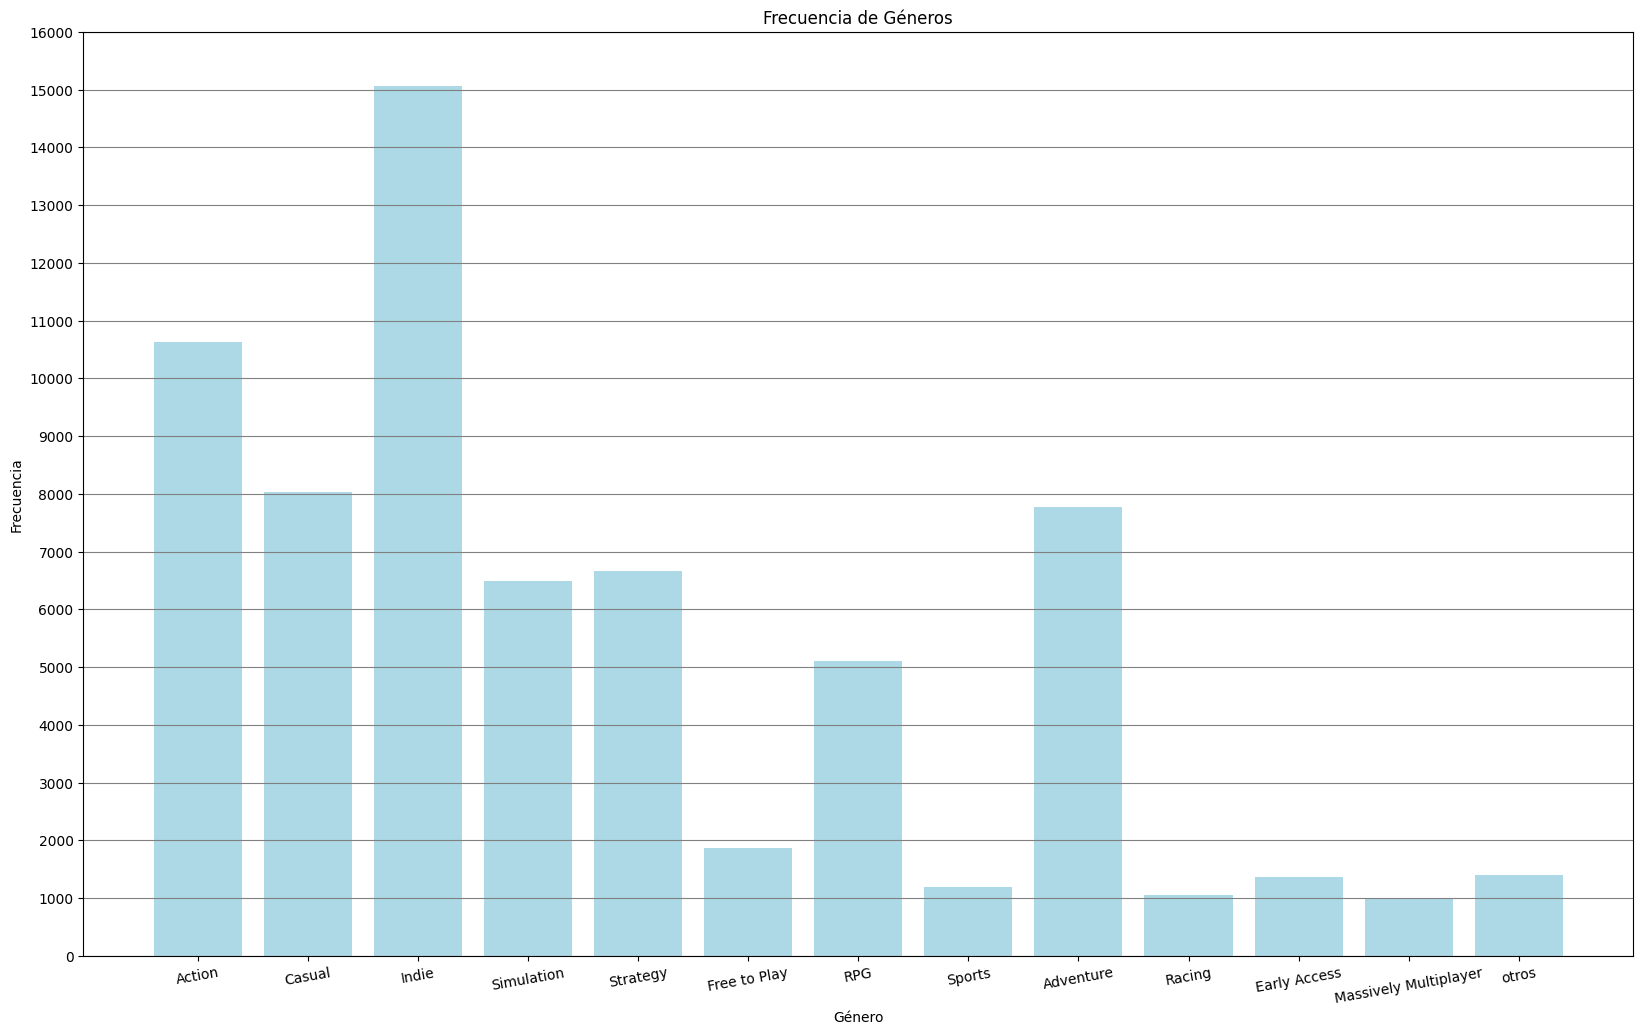

In [12]:
# Contamos las veces que aparece un género en los géneros.
conteo = genres_d.sum()
# Un umbral, ya que son muchas variables, las que no lo superen, serán de la categoría otros.
umbral = 500
# Contamos los juegos menor al umbral.
otros = conteo[conteo < umbral].sum()
# Contamos los que son mayores o iguales al umbral.
conteo = conteo[conteo >= umbral]
# Creamos la columna otros.
conteo['otros'] = otros
# Creamos la figura, con los datos obtenidos.
plt.figure(figsize=(20, 12)) 
plt.bar(conteo.index, conteo.values, color='lightblue')
plt.xlabel('Género')
plt.xticks(rotation=10)
plt.yticks(range(0, int(max(conteo.values)+1000), 1000))
plt.ylabel('Frecuencia')
plt.grid(axis='y', color='gray')
plt.title('Frecuencia de Géneros')

Ahora las especificaciones.

Text(0.5, 1.0, 'Frecuencia de Specs')

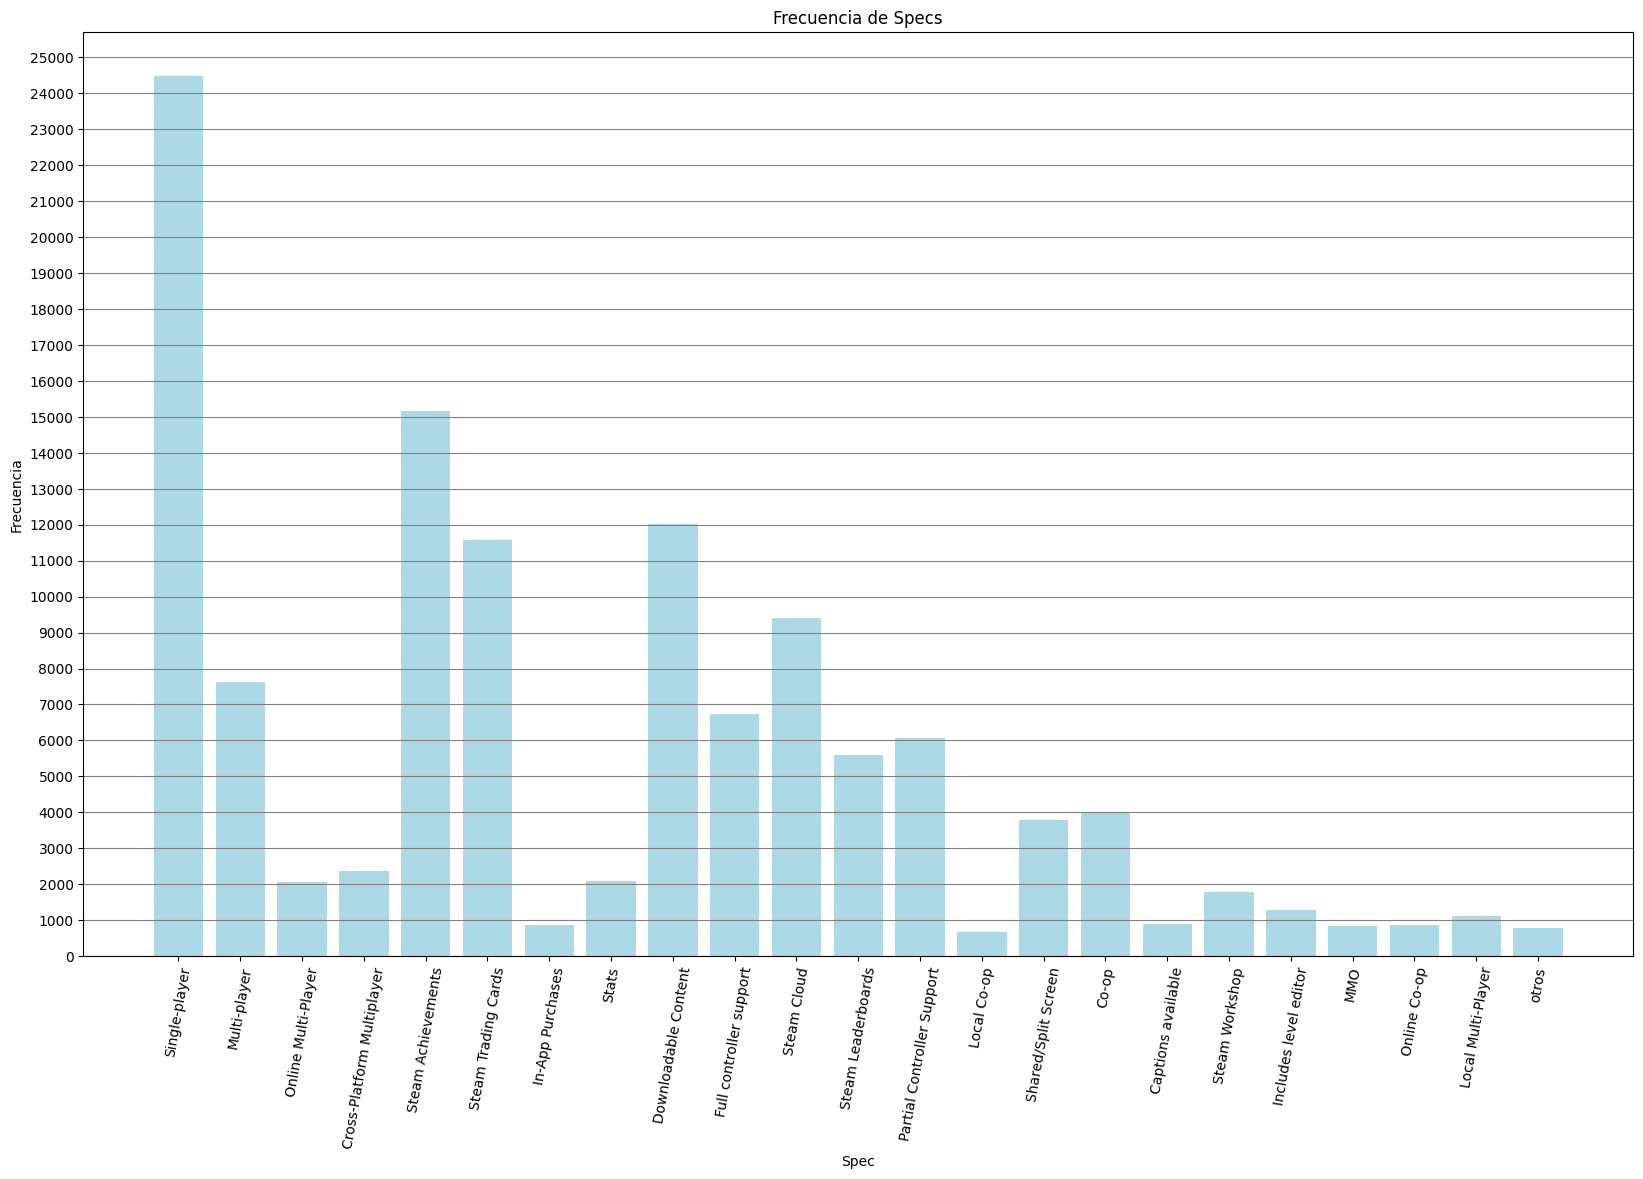

In [13]:
# Contamos las veces que aparece una spec entre todas.
conteo = specs_d.sum()
# Un umbral, ya que son muchas variables, las que no lo superen, serán de la categoría otros.
umbral = 500
# Contamos los juegos menor al umbral.
otros = conteo[conteo < umbral].sum()
# Contamos los que son mayores o iguales al umbral.
conteo = conteo[conteo >= umbral]
# Creamos la columna otros.
conteo['otros'] = otros
# Creamos la figura, con los datos obtenidos.
plt.figure(figsize=(20, 12)) 
plt.bar(conteo.index, conteo.values, color='lightblue')
plt.xlabel('Spec')
plt.xticks(rotation=80)
plt.yticks(range(0, int(max(conteo.values)+1000), 1000))
plt.ylabel('Frecuencia')
plt.grid(axis='y', color='gray')
plt.title('Frecuencia de Specs')

## 4.2 Limpieza en base a la observación

En este caso, filtré las variables para que si llegaban a aparecer más de 500 veces, se mostraran como otros, en el caso de Géneros, podemos ver que hay varias variables que dominan en este umbral, como lo son indie, acción, casual, simulación, estrategia, aventura y RPG, mientras que en el caso de specs, la variable single player domina mucho más que las demás, luego, también llegan a verse varias variables que logran superar el umbral por bastante.

Analizando esto, decido realizar una limpieza a los datos, ya que tenemos una gran cantidad de variables que no llegarán a ser muy significativas para el modelo, para esto uso el identificador de componentes principales PCA de scikit learn, el cual nos ayudará a identificar cuantas variables principales queremos en nuestro dataframe, y a obtener un valor dentro de esas variables, que logre abarcar al dataframe de una manera más óptima, he decidido crear 10 componentes, después de efectuar unas visualizaciones manuales y de ver cómo se comportaba con distintos números. Además, el PCA no se limita a valores positivos, sino a negativos, por lo que filtrará mejor el dataframe si se planea saber cuales juegos son menos similares a otros. Entiendo que el PCA no es la manera más óptima de reducir un set de datos con variables categóricas, pero puede ayudar a reducir rápidamente la dimensionalidad que estamos teniendo en este set para lograr el Mvp(Producto viable mínimo), y se planteará usar una tecnología específica para categorización a futuro.

In [14]:
# Creo el analizador de componentes principales.
pca = PCA(n_components=10)
# Obtenemos una matriz de dichos componentes, excluyendo el id y el nombre, ya que estos no son características, son identificadores.
df_pca = pca.fit_transform(df_games.drop(columns=['id', 'name']))

In [15]:
# Creo un dataframe en base a la matriz, con las columnas de 1 a 10.
df_pca = pd.DataFrame(data=df_pca, columns=[str(n) for n in range(1, 11)])
# Agrego el id y el nombre correspondiente al dataframe de los componentes principales.
df_pca = pd.concat([df_games[['id', 'name']], df_pca], axis=1)

Observamos el dataframe resultante.

In [16]:
df_pca.head()

,id,name,1,2,3,4,5,6,7,8,9,10
0,761140,Lost Summoner Kitty,-0.663424,-0.394529,-0.402296,0.307438,0.771669,-0.544150,0.039934,-0.064927,-0.255702,0.140794
1,643980,Ironbound,-0.352296,0.314932,0.899000,1.389335,0.086969,0.263993,-0.681269,0.650172,0.039089,-0.062176
2,670290,Real Pool 3D - Poolians,-0.688840,0.202145,-0.370959,0.441656,1.035726,-0.533025,0.172840,0.696757,0.323371,0.726916
3,767400,弹炸人2222,-0.658009,-0.771362,-0.357642,-0.729574,0.128192,0.070451,0.242556,0.284600,0.725868,-0.257765
4,772540,Battle Royale Trainer,-0.107585,-0.468937,-0.251006,-0.742221,-0.228599,0.067278,-0.342901,0.020923,0.232786,0.589541


Con las variables convertidas, exportamos el set de datos para su uso en el cuaderno de Machine Learning, en el cual se usará la similitud del coseno para hallar los N productos similares necesarios.

In [17]:
df_pca.to_csv('games_ML.csv', index=False)

# 5. Análisis de datos (General)
Analizamos los demás datos.

Observamos que no haya quedado ningún nulo en el previo ETL.

In [18]:
df_game.isna().sum()

publisher       19
genres           0
name             0
specs            0
price            0
early_access     0
id               0
developer        0
year             0
dtype: int64

Borramos los nulos

In [19]:
df_game.dropna(inplace=True)

Previsualizamos nuevamente el dataframe

In [20]:
df_game.head(3)

,publisher,genres,name,specs,price,early_access,id,developer,year
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,['Single-player'],4.99,0.0,761140,Kotoshiro,2018
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,"['Single-player', 'Multi-player', 'Online Mult...",0.00,0.0,643980,Secret Level SRL,2018
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,"['Single-player', 'Multi-player', 'Online Mult...",0.00,0.0,670290,Poolians.com,2017


In [21]:
df_game['price'].describe()

count    27154.000000
mean         8.688669
std         14.733370
min          0.000000
25%          2.990000
50%          4.990000
75%          9.990000
max        995.000000
Name: price, dtype: float64

Podemos ver que en promedio, un juego cuesta 8 dólares en steam, sin embargo, esto esta un poco lejos de la media, y el valor máximo son casi mil dólares, por lo que claramente debe haber outliers en el set de datos, identifiquémonos con la desviación estándar, los valores que estén 3 veces más veces lejos la desviación que la media, los consideraremos outliers para una mejor visualización de los precios bajos, esto no significa que los outliers descartados sean errores, ya que los juegos, suelen tener distintos estudios, y la mayoría son pequeños, mientras que la minoría son estudios grandes que producen videojuegos triple A, los cuales pueden llegar a vales mucho y generar estos outliers. Aunque hay excepciones, como el precio de 995 dólares, que es muy probable que sea un outlier (o un juego que incluya hacerte el desayuno todos los días).

In [22]:
n = 3 # Establezco un valor alto en la detección, para que así no tome falsos positivos, ya que los juegos, pueden tener una alta varianza, siendo unos triple A y otros de estudios indie, y, aplicaciones de animación y derechos de distribución que pueden ser costosas.

# Extraemos la media, la varianza, y definimos los límites.
mean = df_game['price'].mean() 
std = df_game['price'].std()
sup = mean + n * std
inf = mean - n * std
# Obtenemos los posibles outliers.
out = df_game[(df_game['price'] > sup) | (df_game['price'] < inf)]

In [23]:
# Creamos los precios sin outliers, obteniendo la mascara de los id que están en precio, para luego negarla y quedarnos con los que no están en precio.
pric_nout = pd.Series(df_game[~(df_game['id'].isin(out['id']))]['price'])

Observemos la distribución de precios, ahora que estos valores tan altos no están.

## 5.1 Distribución de precios.

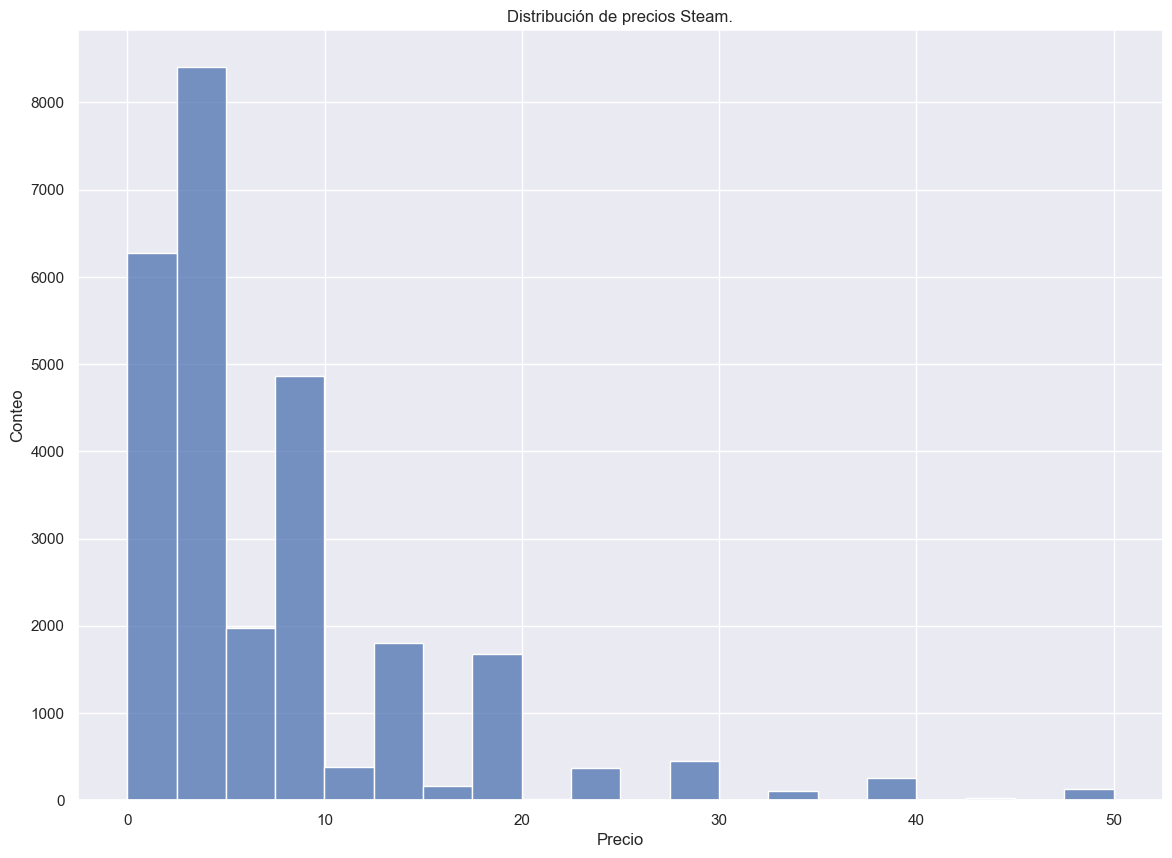

In [24]:
plt.figure(figsize=(14, 10))
sns.set(style='darkgrid')
ax = sns.histplot(pric_nout, bins=20)
ax.set(xlabel='Precio', ylabel='Conteo')
ax.set_title("Distribución de precios Steam.")
plt.show()

Podemos observar que dentro del rango de 0 a 10 dólares, se encuentran la gran mayoría de los artículos de steam, mientras que al pasar de 10 a 20, aún se encuentra una pequeña cantidad, no pasa lo mismo con los mayores a 20, que ya son muy pocos y no representan casi nada del set de datos, también podemos observar que la suma favorita para los juegos radica entre 2.5 y 5 dólares, observemos con la moda cuál es.

In [25]:
pric_nout.mode()

0    4.99
Name: price, dtype: float64

La moda es 5 dólares, pero, en formato 4.99 para la clásica estrategia de quitar el valor entero 5, y que nos fijemos en el 4, esta parece ser la suma preferida de los desarrolladores, esto debido a que la mayoría de estudios, aún pueden ganar una buena cantidad de dinero con esta suma, y una buena cantidad de atención en su juego, al no ser una suma alta.

## 5.2 Distribución estudios y publishers.

Ahora observemos qué estudios abarcan la mayor cantidad de juegos.

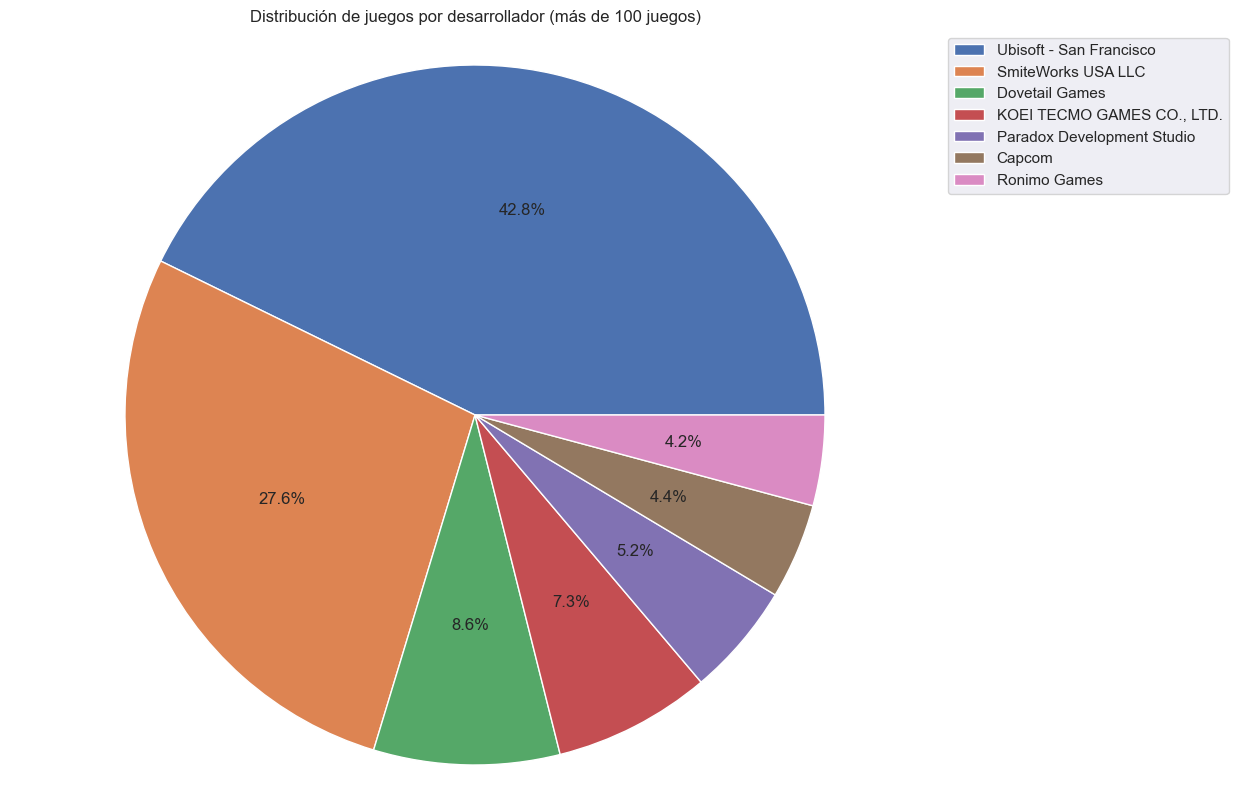

In [26]:
import matplotlib.pyplot as plt

# Obtenemos los desarrolladores con más de 100 juegos lanzados para no saturar el gráfico.
dev_count = df_game['developer'].value_counts()
dev_count_f = dev_count[dev_count > 100]

# Creamos el gráfico.
plt.figure(figsize=(12, 10))
plt.pie(dev_count_f, autopct='%1.1f%%')
plt.title('Distribución de juegos por desarrollador (más de 100 juegos)')
plt.axis('equal')
# Mostramos los desarrolladores con su color.
plt.legend(dev_count_f.index, bbox_to_anchor=(1, 1))
plt.show()


Podemos ver que Ubisoft-San Francisco abarca el 42.8% de los juegos de los desarrolladores grandes, esto es casi la mitad lo que nos dice que el estudio genera mucho contenido, siendo el segundo puesto SmiteWorks USA LLC con 27.6 %, deja a todos los demás estudios juntos con menos de la cifra que abarca Ubisoft. Veamos si pasa lo mismo con los publisher.

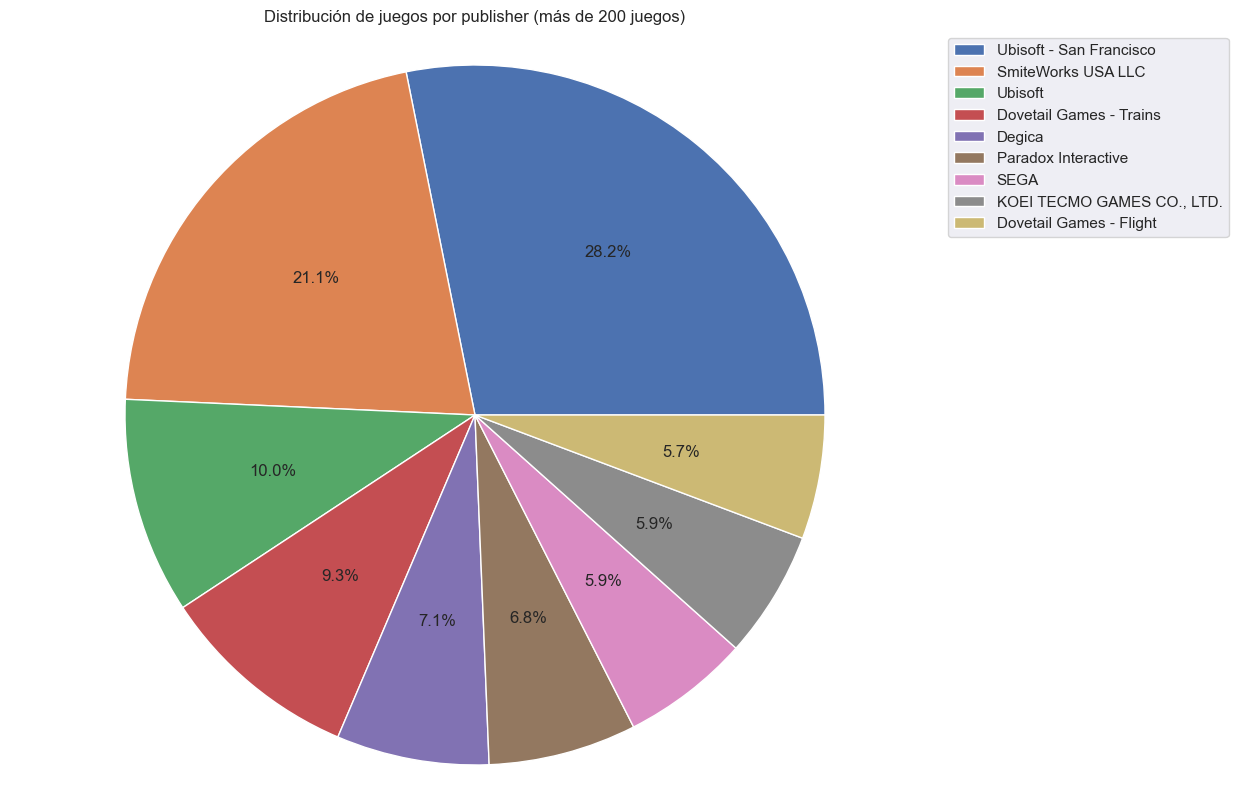

In [27]:
import matplotlib.pyplot as plt

# Obtenemos los publisher con más de 200 juegos publicados para no saturar el gráfico.
pub_count = df_game['publisher'].value_counts()
pub_count_f = pub_count[pub_count > 200]

# Creamos el gráfico.
plt.figure(figsize=(12, 10))
plt.pie(pub_count_f, autopct='%1.1f%%')
plt.title('Distribución de juegos por publisher (más de 200 juegos)')
plt.axis('equal')
# Mostramos los publisher con su color.
plt.legend(pub_count_f.index, bbox_to_anchor=(1, 1))
plt.show()


Ubisoft y Smiteworks siguen teniendo una gran parte del gráfico, esta vez siendo aproximadamente un 5% total menos para Ubisoft. También podemos observar que la variedad y distribución de estudios cambió, siendo mayor la variabilidad en los developer.